# Separate Channel Transmission of Pseudonum

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import statistics as stats

In [25]:
'''
Protocol parameters!!!
'''
samples = 6000 # number of data samples per pseudonym bit
FFT = 64 # FFT size for extracting IQ sample in each subcarrier
OFDM_size = 80 # OFDM symbol with cyclic prefix
pseudonym_len = 4
pream_length = 352
pattern_sample = samples//10
mess_length = samples*OFDM_size*pseudonym_len 
Frame_length = mess_length + pream_length

In [26]:
pseudonym_packet = np.zeros((pseudonym_len,1)) ## Transmitted pseudonym bit sequence
for i in range(pseudonym_len):
    if i%2 == 0:
        pseudonym_packet[i] = 1

In [27]:
dataCarriers = np.array([-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,
                    -5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])

pseudonymChannel2 = np.array([16])

guardCarriers = np.array([-32,-31,-30,-29,-28,-27,26,27,28,29,30,31])

p_bit0_pattern = np.array([0,1,0,1,0,1,0,1,0,1])
p_bit1_pattern = np.array([1,0,1,0,1,0,1,0,1,0])

pseudo_channels = np.array([43,44,45,46,47,48,49,50,51,52])

In [28]:
def OFDM_TX(message_len):
    CP = 16  # 25% Cyclic Prefix 
    M = 2 # bits per symbol (i.e. QPSK)
    mod_index = 1.0
    bits = np.random.binomial(n=1, p=0.5, size=(message_len,))
 
    for i in range(len(bits)//(2*FFT)):
        
        data_bits = bits[i*2*FFT:(i+1)*2*FFT]

        # Convert serial data to parallel
        def Serial_to_Parallel(x):
            return x.reshape((FFT, M))
        parallel_bits = Serial_to_Parallel(data_bits)

        # mapping table
        ## maps data_bits into complex value IQ samples
        mapping_table = {
            (0,0) : 1.4142 + 1.4142j,
            (0,1) : -1.4142 + 1.4142j,
            (1,0) : 1.4142 - 1.4142j,
            (1,1) : -1.4142 - 1.4142j
        }

        # mapping
        def Mapping(x):
            return np.array([mapping_table[tuple(b)] for b in x])
        
        QPSK = Mapping(parallel_bits)
#         print('Length of QSPS',len(QPSK))
        # OFDM symbol generation
        def OFDM_symbol_gen(x):
            pilot_value = np.array([1.4142 + 1.4142j, -1.4142 - 1.4142j, 1.4142 + 1.4142j, -1.4142 - 1.4142j])
            guard_value = np.array([0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j])
            
            symbol = np.zeros(FFT, dtype=np.complex64)
            symbol[dataCarriers] = QPSK[dataCarriers]
            #symbol[pilotCarriers] = pilot_value
            symbol[guardCarriers] = guard_value
            return symbol
        
        OFDM_symbol = OFDM_symbol_gen(QPSK)

        # Pseudonym Embedding Scheme
        # Embeds the pseudonyms on to the subcarriers
        
        def Pseudonym_Embedding(x):
            if i < len(bits)//(4*FFT):
                      
                if (i//pattern_sample)%2 == 0: 
#                      
                    x[pseudonymChannel2] = x[pseudonymChannel2]*(1+mod_index) 
                else:
#                    
                    x[pseudonymChannel2] = x[pseudonymChannel2]*(1-mod_index) 
            else:
                if (i//pattern_sample)%2 == 0:
#                     
                    x[pseudonymChannel2] = x[pseudonymChannel2]*(1-mod_index) 
                else:
#                     
                    x[pseudonymChannel2] = x[pseudonymChannel2]*(1+mod_index)
            return x
        
        modulated_OFDM = Pseudonym_Embedding(OFDM_symbol)
        
        # Generate time domain signal
        def IDFT(x, n=64):
            return np.fft.ifft(x,n)
        
        OFDM_time = IDFT(modulated_OFDM)

        # adding cyclic prefix
        def addCP(x):
            cp = x[-CP:]              
            return np.hstack([cp, x]) 
        OFDM_withCP = 3*addCP(OFDM_time)
        if i == 0:
            OFDM_swap = OFDM_withCP
        else:
            OFDM_signal = np.hstack([OFDM_swap, OFDM_withCP])
            OFDM_swap = OFDM_signal
#         print('Length of waveform:',len(OFDM_swap))
    return OFDM_signal

In [29]:
'''Generate pseudonym packet'''
def Generate_pseudonym_packet(num_pbits):   
    for i in range(num_pbits):
        OFDM_samples = OFDM_TX(4*FFT*samples)
        if i ==0:
            OFDM_swap = OFDM_samples
        else:
            OFDM_signal = np.hstack([OFDM_swap, OFDM_samples])
            OFDM_swap = OFDM_signal
    return OFDM_signal

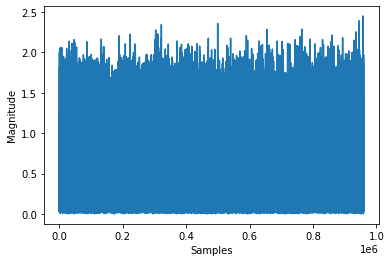

480000.0


In [30]:
OFDM_samples = OFDM_TX(4*FFT*samples)
# OFDM_samples = OFDM_TX(1536000)
#np.save('OFDM_signal_save',OFDM_samples)
plt.plot(abs(OFDM_samples))
plt.ylabel("Magnitude")
plt.xlabel("Samples")
plt.show()
print(len(OFDM_samples)/2)

In [ ]:
# Compute the peak to average ratio for the OFDM subchannels.
def Peak2Average_Ratio(x)
    

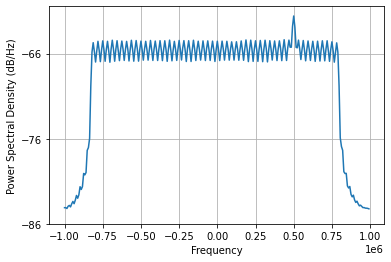

In [31]:
plt.psd(OFDM_samples, Fs = 2e6)#, Fc = 3655e6)
#plt.savefig('Carrier_power.eps', bbox_inches='tight')
plt.show()

In [32]:
OFDM_waveform = Generate_pseudonym_packet(pseudonym_len//2)
len(OFDM_waveform)

1920000

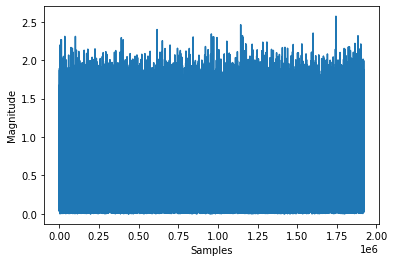

In [33]:
# OFDM_samples = OFDM_TX(1536000)
#np.save('OFDM_signal_save',OFDM_samples)
plt.plot(abs(OFDM_waveform))
plt.ylabel("Magnitude")
plt.xlabel("Samples")
plt.show()

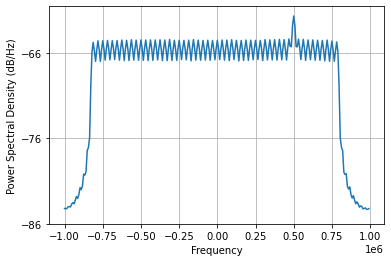

In [34]:
plt.psd(OFDM_waveform, Fs = 2e6)#, Fc = 3655e6)
plt.savefig('Carrier_power.eps', bbox_inches='tight')
plt.show()

# Add preamble for synch

In [35]:
# PURPOSE: Convert binary data to M-ary by making groups of log2(M)
#          bits and converting each bit to one M-ary digit.
# INPUT: Binary digit vector, with length as a multiple of log2(M)
# OUTPUT: M-ary digit vector
def binary2mary(data, M):

    log2M   = round(np.log2(M))
    # integer number of bits per group
    if (len(data) % log2M) != 0:
        print('Input to binary2mary must be divisible by log2(m).')
    data.shape = (len(data)//log2M, log2M)
    binaryValuesArray = 2**np.arange(log2M)
    marydata = data.dot(binaryValuesArray)
    return marydata

In [36]:
# PURPOSE: convert input data stream to signal space values for
#          a particular modulation type (as specified by the inputVec
#          and outputVec).
# INPUT: data (groups of bits)
# OUTPUT: signal space values
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    # Initialize output
    output = np.zeros(data.shape)
    # For each possible data value
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

In [37]:
# PURPOSE: insert 0's between samples to oversample at OS_Rate
# INPUT: x (data), OS_Rate (how frequently data occurs)
# OUTPUT: x_s (oversampled data)
def oversample(x, OS_Rate):
    # Initialize output
    length = len(x[0])
    x_s = np.zeros((1,length*OS_Rate))
    # Fill in one out of every OS_Rate samples with the input values
    count = 0
    h = 0
    for k in range(len(x_s[0])):
        count = count + 1
        if count == OS_Rate:
            x_s[0][k] = x[0][h]
            count = 0
            h = h + 1
    return x_s

In [38]:
# PURPOSE: create a square root raised cosine pulse shape
# INPUT: alpha, N, Lp
# OUTPUT: pulse wave array for srrc
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    n = np.arange(-N*Lp+ (1e-9), N*Lp+1)
    h = np.zeros(len(n))
    coeff = 1/np.sqrt(N)
    for i, each in enumerate(n):
        sine_term = np.sin(np.pi * each * (1-alpha) / N)
        cosine_term = np.cos(np.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = np.pi * each / N
        denom_part = 1 - cosine_coeff**2
        denominator = denom_coeff * denom_part
        h[i] = coeff * numerator / denominator
    return h

In [39]:
# PURPOSE: create a modulated signal with the defined preamble
# INPUT: A (sqrt value for modulation), N, alpha, Lp (for srrc)
# OUTPUT: modulated preamble signal & srrc pulse
def createPreambleSignal(A, N, alpha, Lp):

    # We defined the preamble as this repeating bit signal:
    preamble     = np.tile([1, 1, 0, 0], 16)

    ###########################################
    ### Signal Generation
    ### INPUT: binary data
    ### OUTPUT: 4-ary data (0..3) values
    data = binary2mary(preamble, 4)

    ###########################################
    ### Modulation
    ### INPUT: data
    ### OUTPUT: modulated values, x
    inputVec   = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]
    xI         = lut(data, inputVec, outputVecI)
    xQ         = lut(data, inputVec, outputVecQ)
    xI = xI.reshape((1,len(data)))
    xQ = xQ.reshape((1,len(data)))
    ###########################################
    ### Upsample
    ### INPUT: modulated values, x
    ### OUTPUT: modulated values at sampling rate, x_s
    x_s_I = oversample(xI, N)
    x_s_Q = oversample(xQ, N)

    ###########################################
    ### Pulse-shape filter
    ### INPUT: modulated values at sampling rate, x_s
    ### OUTPUT: baseband transmit signal s

    pulse = SRRC(alpha, N, Lp)
    pulse = np.array(pulse)
    pulse = np.reshape(pulse, pulse.size)
    x_s_I = np.reshape(x_s_I, x_s_I.size)
    x_s_Q = np.reshape(x_s_Q, x_s_Q.size)
    s_0_I = np.convolve(x_s_I, pulse, mode='full')
    s_0_Q = np.convolve(x_s_Q, pulse, mode='full')
#     plt.figure()
#     plt.plot(pulse,label='SRRC pulse shape')
#     plt.legend()
#     plt.show()
    
    preamb = s_0_I + 1j*s_0_Q
    ## Add zero-padding at the beginning
    ##preamb = np.insert(s,0,np.zeros(1024))
    
#     plt.figure()
#     plt.plot(np.real(preamb),label='Real Signal')
#     plt.plot(np.imag(preamb),label='Imag Signal')
#     plt.grid('on')
#     plt.legend()
#     plt.show()
    return preamb, pulse

352


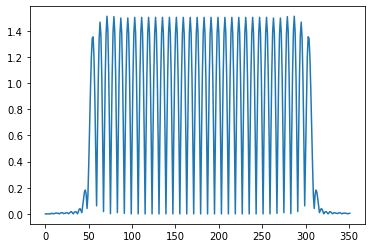

In [40]:
A = np.sqrt(9/2)
N = 8
alpha = 0.5
Lp = 6
preambleSignal,pulse = createPreambleSignal(A, N, alpha, Lp)
print(len(preambleSignal))
plt.plot(abs(preambleSignal))

## Save preamble to file

In [41]:
def write_data_to_file(data, filename):
    
    '''
    Saves preamble to file for later use
    '''

    data.tofile(filename) 

In [42]:
# write_data_to_file(preambleSignal, 'Preamble')

In [43]:
def get_samps_from_file(filename): 
    '''
    load samples from file
    '''
    samps = np.fromfile(filename)
    return samps

In [44]:
# preamb = get_samps_from_file('Preamble')
# plt.plot(abs(preamb))

In [45]:
# Concatenate preamble signal and message signal
PAM_modulated_OFDM = np.concatenate((preambleSignal,OFDM_waveform))
print(len(PAM_modulated_OFDM))

1920352


In [46]:
# PURPOSE: perform preamble synchronization
#          Uses the (complex-valued) preamble signal. The cross-correlation 
#          of the preamble signal and the received signal (at the time
#          when the preamble is received) should have highest magnitude
#          at the index delay where the preamble approximately starts.  
# INPUT:   rx0: received signal (with a frequency offset)
#          preambleSignal: complex, known, transmitted preamble signal 
# OUTPUT:  lagIndex: the index of rx0 where the preamble signal has highest 
#              cross-correlation
#
def crossCorrelationMax(rx0, preambleSignal):

    # Cross correlate with the preamble to find it in the noisy signal
    lags      = signal.correlation_lags(len(rx0), len(preambleSignal), mode='valid')
    xcorr_out = signal.correlate(rx0, preambleSignal, mode='valid')
    xcorr_mag = np.abs(xcorr_out)
    # Don't let it sync to the end of the packet.
    packetLenSamples = 0
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-packetLenSamples])
    lagIndex = lags[maxIndex]

    print('Max crosscorrelation with preamble at lag ' + str(lagIndex))

    # Plot the selected signal.
    plt.figure()
    fig, subfigs = plt.subplots(2,1)
    subfigs[0].plot(np.real(rx0), label='Real RX Signal')
    subfigs[0].plot(np.imag(rx0), label='Imag RX Signal')
    scale_factor = np.mean(np.abs(rx0))/np.mean(np.abs(preambleSignal))
    subfigs[0].plot(range(lagIndex, lagIndex + len(preambleSignal)), scale_factor*np.real(preambleSignal), label='Preamble')
    #subfigs[0].legend()
    subfigs[1].plot(lags, xcorr_mag, label='|X-Correlation|')
    plt.xlabel('Sample Index', fontsize=14)
    #plt.tight_layout()

    return lagIndex

Max crosscorrelation with preamble at lag 0


0

<Figure size 432x288 with 0 Axes>

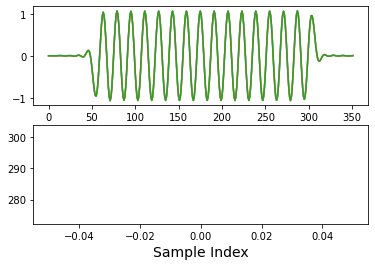

In [64]:
#crossCorrelationMax(preambleSignal,preambleSignal)

## Add 1024 padded zeros at the beginning

In [48]:
PAM_modulated_OFDM_Final = np.hstack([np.zeros(1024, dtype=type(PAM_modulated_OFDM[0])),PAM_modulated_OFDM])
print(len(PAM_modulated_OFDM_Final))

1921376


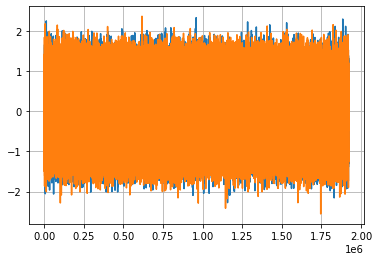

In [49]:
plt.figure()
plt.plot(np.real(PAM_modulated_OFDM_Final),label='Real Signal')
plt.plot(np.imag(PAM_modulated_OFDM_Final),label='Imag Signal')
plt.grid('on')
#plt.legend()
plt.show()

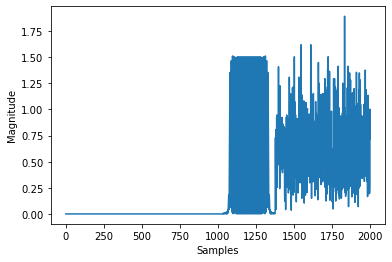

In [50]:
plt.plot(abs(PAM_modulated_OFDM_Final[:2000]))
plt.ylabel("Magnitude")
plt.xlabel("Samples")
plt.show()

# Generate iq data for transmission over GNU radio

In [51]:
def write_complex_binary(data, filename):
    '''
    Open filename and write array to it as binary
    Format is interleaved float IQ e.g. each I,Q should be 32-bit float 
    INPUT
    ----
    data:     data to be wrote into the file. format: (length, )
    filename: file name
    '''

    re = np.real(data)
    im = np.imag(data)
    binary = np.zeros(len(data)*2, dtype=np.float32)
    binary[::2] = re
    binary[1::2] = im
    binary.tofile(filename) 

In [52]:
#write_complex_binary(PAM_modulated_OFDM_Final, 'TX_pattern_one_channel_Feb27_2024.iq')

# Separate Pseudonym subchannel Receiver Below

In [53]:
## FFT for data of window size=64
def DFT_data(x, n =64):
    return np.fft.fft(x,n)

In [54]:
''' Calculates FFT to recover the frequency domain signal in subcarriers and stores them in a matrix '''

def subchannel_data(x):
    sort_data = np.zeros((FFT, len(x)//OFDM_size), dtype = np.complex64)
    for i in range(len(x)//OFDM_size):
        y = x[i*OFDM_size:(i+1)*OFDM_size]
        sort_data[:,i] = np.fft.fftshift(DFT_data(y[0:FFT]))  
    return sort_data

In [55]:
## calculate the power in each pseudonym bit and store it in matrix
def Cal_subch_power(x):
    sub_power = np.zeros((FFT,1))
    for i in range(FFT-1):
        sub_power[i] = sum(abs(x[i,:])**2) 
    return sub_power

In [56]:
'''
calculates the distance between two arrays.
'''
def Distance(X,Y):
    count = 0
    for i in range(len(X)):
        if X[i]!= Y[i]:
            count +=1
    return count

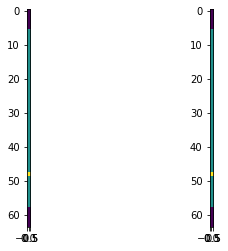

In [57]:
data1 = subchannel_data(OFDM_waveform[:2*OFDM_size*samples])
power = Cal_subch_power(data1[:,1:samples])
plt.subplot(1,2,1)
plt.imshow(abs(power))
power = Cal_subch_power(data1[:,samples:2*samples])
plt.subplot(1,2,2)
plt.imshow(abs(power))
plt.show()

In [58]:
## Make p-bit decisions by comparing patterns on bit-0 and bit-1
## the patterns are 1010101010 for p-bit 1 and 0101010101 for p-bit 0
def Pseudonym_Detection(x):
    p_bit = []
    for i in range(pseudonym_len):
        pbit_data = x[i*OFDM_size*samples:(i+1)*OFDM_size*samples] # slices samples into one p-bit data
        
        r_bit_pattern2 = []
        power2 = []
        for j in range(len(p_bit0_pattern)):
            chip_data = pbit_data[j*OFDM_size*pattern_sample:(j+1)*OFDM_size*pattern_sample]
            FFT_matrix = subchannel_data(chip_data)
            subchannel_power = Cal_subch_power(FFT_matrix)
            power2.append(subchannel_power[48,0])
        
#             index_max = np.argmax(subchannel_power)
#             print("Index of max:",index_max)
    
        for k in range(len(p_bit0_pattern)):
            if power2[k] > np.mean(sorted(power2, reverse = False)[2:9]):
                r_bit_pattern2.append(1)
            else:
                r_bit_pattern2.append(0)
                
    
                
        print("detected pattern:",r_bit_pattern2)
        plt.plot(power2)
        plt.show()
        d21 = Distance(r_bit_pattern2, p_bit1_pattern)
        d20 = Distance(r_bit_pattern2, p_bit0_pattern)
       
        
        if (d21) < (d20):
            p_bit.append(1)
        else:
            p_bit.append(0)  
    return np.array(p_bit)

In [59]:
## Make p-bit decisions by comparing patterns on bit-0 and bit-1
## the patterns are 1010101010 for p-bit 1 and 0101010101 for p-bit 0
def Pseudonym_Detection3(x):
    p_bit = []
    for i in range(pseudonym_len):
        pbit_data = x[i*OFDM_size*samples:(i+1)*OFDM_size*samples] # slices samples into one p-bit data
        
        r_bit_pattern = []
        power = []
        for j in range(len(p_bit0_pattern)):
            chip_data = pbit_data[j*OFDM_size*pattern_sample:(j+1)*OFDM_size*pattern_sample]
            FFT_matrix = subchannel_data(chip_data)
            subchannel_power = Cal_subch_power(FFT_matrix)
            power.append(subchannel_power[48,0])
            
#             index_max = np.argmax(subchannel_power)
#             print("Index of max:",index_max)
    
        for k in range(len(p_bit0_pattern)-1):
            if power[k] > power[k+1]:
                r_bit_pattern.append(1)
            else:
                r_bit_pattern.append(0)
                
        if power[8] < power[9]:
            r_bit_pattern.append(1)
        else:
            r_bit_pattern.append(0)

                
#        print("detected pattern:",r_bit_pattern2)
#         plt.plot(power2)
#         plt.show()
        d21 = Distance(p_bit1_pattern,r_bit_pattern)
        d20 = Distance(p_bit0_pattern,r_bit_pattern)

        if (d21) < (d20):
            p_bit.append(1)
        else:
            p_bit.append(0)  
    return np.array(p_bit)

In [60]:
''' Calculates the pseudonym bit error by comparing the detected pseudonym bits 
to the transmitted pseudonym bits.
'''
def Pseudonym_BER(x):
    preds = Pseudonym_Detection3(x)
    p_bit_error = Distance(preds,pseudonym_packet)
    return p_bit_error

In [61]:
Pseudonym_BER(OFDM_waveform)

0

In [62]:
lagindex = 10487165
# Load data from file
def readCom(file_path):
    return np.fromfile(file_path, dtype=np.complex64)

In [63]:
# Rx = readCom("Phantom_single_30dB")
# crossCorrelationMax(Rx[int(1e7):], preambleSignal)